In [1]:
import pandas as pd
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.image as mpimg

input_csv_path contains the csv file with the original set, every image has 6 rows, 5 rows refers to a kind of hemorrhage and the 6th shows if there's any kind. Images are indexed by a unique identifier ID
output_csv_path is the output folder that will contain a subset of the previous csv file with just a row for image and it will not contain all the dataset but a balanced subset.
input_dicom_folder contains all the images, they are organized in subfolders and their format is dicom
output_dicom_folder will contain processed images
backup_npy is a utility folder where we will save our numpy arrays

In [2]:
input_csv_path = '/eos/user/g/gamorell/test/csv_test.csv'
output_csv_path = '/eos/user/g/gamorell/test/filtered.csv'

input_dicom_folder = '/eos/user/g/gamorell/test/img'
output_dicom_folder = '/eos/user/g/gamorell/test/processed/'
output_dicom_folder_head = '/eos/user/g/gamorell/test/processed/img_'

backup_npy = '/eos/user/g/gamorell/test/npy/'

SIZE = 128               #final size of converted images
DEBUG = 0                #check converting_img()

Starting from the original csv file we select a subset of entries, we are taking into account whether an image has a hemorrhage or not, we are not considering the type and we are ignoring uncertain values (0,1). We will select all those entries where the "any" field is 1 and a subset of those where "any" is 0 of the same size of the first one, to have a balanced set.
After opening the csv file, we select rows where ID contains "any", then we take Label equal to one to make the first half of our set. We select a number of row with Label equal to zero of the same size of the first set. In the end we append the second to the first one and we save our results. 

In [3]:
def create_csv():
    raw_data = pd.read_csv(input_csv_path, usecols = ['ID', 'Label'])
    filtered = raw_data[raw_data["ID"].str.contains("_any")]
    flaired_data = filtered[filtered["Label"] == 1]
    
    unflaired_data = filtered[filtered["Label"] == 0]                          #too big (6 times the size of flaired)
    unflaired_data_head = unflaired_data.head(int(flaired_data.size/2))
    
    final_set = flaired_data.append(unflaired_data_head)
    final_set.to_csv(output_csv_path, index = False)
create_csv()


In [4]:
our_images = pd.read_csv(output_csv_path, dtype = str)
our_images

,ID,Label
0,ID_0002081b6_any,1
1,ID_0002a38ad_any,1
2,ID_000346ce2_any,1
3,ID_00042829c_any,1
4,ID_0004a5701_any,1
5,ID_00058bb06_any,1
6,ID_0005d340e_any,1
7,ID_000744022_any,1
8,ID_0007b8af4_any,1
9,ID_00083d407_any,1


The next block contains utility functions to manage paths and ID, note that results are saved in a npy file to prevent memory issues and to improve modularity. clean_str takes our previous result and it manipulate its strings to remove the "any" part, it also converts the pandas DataFrame to a numpy array. The second function create_path_list() organizes IDs to have a path for every image. os.walk scans the dicom folder and all its subfolder. At the end we save our results in a npy array. 

In [5]:
def clean_str():
    our_images = pd.read_csv(output_csv_path, dtype = str)
    pylist = our_images.values.tolist()
    for str_id in pylist:
        str_id[0] = str_id[0].rsplit('_', maxsplit = 1)[0]
    nplist = np.array(pylist).T
    np.save(backup_npy + 'data.npy', nplist)
clean_str()

def create_path_list():
    np_list = np.load(backup_npy + 'data.npy')
    file_list = []
    for root, dirs, files in os.walk(input_dicom_folder):
        for file in files:
            if(file.split('.')[0] in np_list[0]):
                file_list.append(root + '/' + file)
    
    np_file = np.array(file_list, dtype = str)
    np.save(backup_npy + 'paths.npy', np_file)
create_path_list()

In [6]:
np_list = np.load(backup_npy + 'data.npy')
np_list

array([['ID_0002081b6', 'ID_0002a38ad', 'ID_000346ce2', 'ID_00042829c',
        'ID_0004a5701', 'ID_00058bb06', 'ID_0005d340e', 'ID_000744022',
        'ID_0007b8af4', 'ID_00083d407', 'ID_0008d8433', 'ID_00094b19b',
        'ID_0009db386', 'ID_0009e5f5e', 'ID_000a050f3', 'ID_000aa2bce',
        'ID_000d66d9e', 'ID_000d69988', 'ID_000ec5e66', 'ID_000edbf38',
        'ID_00101d495', 'ID_00107f7a9', 'ID_0011ecc1b', 'ID_0011f02f5',
        'ID_001212532', 'ID_0012b5d89', 'ID_00130b866', 'ID_0013294ae',
        'ID_0015e926e', 'ID_00170833c', 'ID_001708921', 'ID_001753ad0',
        'ID_00178eb80', 'ID_0018428e1', 'ID_0018abbe1', 'ID_0019445aa',
        'ID_0019a61ed', 'ID_001af7f51', 'ID_001b1b944', 'ID_001b7abe3',
        'ID_001bb2c00', 'ID_001c0458a', 'ID_001c923b0', 'ID_001c9a9e4',
        'ID_001cc58e9', 'ID_001d37aff', 'ID_001d4ce1c', 'ID_001d83cce',
        'ID_001de8b5a', 'ID_001df2d0f', 'ID_001e00f13', 'ID_001f8e12d',
        'ID_001faa58f', 'ID_001fed527', 'ID_002011516', 'ID_0021

In [7]:
np_file = np.load(backup_npy + 'paths.npy')
np_file

array(['/eos/user/g/gamorell/test/img/ID_000039fa0.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002081b6.dcm',
       '/eos/user/g/gamorell/test/img/ID_000229f2a.dcm',
       '/eos/user/g/gamorell/test/img/ID_000230ed7.dcm',
       '/eos/user/g/gamorell/test/img/ID_00027c277.dcm',
       '/eos/user/g/gamorell/test/img/ID_000280440.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002a38ad.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002adc14.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002d438a.dcm',
       '/eos/user/g/gamorell/test/img/ID_000346ce2.dcm',
       '/eos/user/g/gamorell/test/img/ID_00042829c.dcm',
       '/eos/user/g/gamorell/test/img/ID_000447d36.dcm',
       '/eos/user/g/gamorell/test/img/ID_0004a5701.dcm',
       '/eos/user/g/gamorell/test/img/ID_00058bb06.dcm',
       '/eos/user/g/gamorell/test/img/ID_0005d340e.dcm',
       '/eos/user/g/gamorell/test/img/ID_0005db660.dcm',
       '/eos/user/g/gamorell/test/img/ID_0005de569.dcm',
       '/eos/user/g/gamorell/te

We load our previous result with all the paths we need, we iterate through it and for every image we open it as a dicom file we convert it in an array of floating point numbers, we convert it to a PIL image to resize it and we scale it to have 8-bit values in a numpy array, at the end we round our values to integers to convert it in a png file and store it
In particular we are applying a look up table to make results "human-friendly". Using the bicubic resample we have a good compromise between quality and performance. Images are saved every iteration and different folder are used to ensure good file management for subsequent operations.

In [8]:
def converting_img():
    np_list = np.load(backup_npy + 'paths.npy')
    for count, str_path in tqdm(enumerate(np_list)):
        if(count > DEBUG):                          #to not start from the beginning in case of problems since this part lasted several hours
            dicom = pydicom.read_file(str_path)
            apply_voi_lut(dicom.pixel_array, dicom) #brightness tuning
            array = dicom.pixel_array.astype(float)
            
            image_r = Image.fromarray(array)
            image_r = image_r.resize((SIZE, SIZE),  resample = PIL.Image.BICUBIC)   #resized
            image_r = np.array(image_r)
            
            image_s = (np.maximum(image_r,0) / image_r.max()) * 255.0   #scaled
            image_s = np.uint8(image_s)
            
            data = Image.fromarray(image_s) #to png
            data.save(output_dicom_folder_head + str(int(np.floor(count/10000))) + '/' + str_path.split('/')[7].split('.')[0] + '.png')
converting_img()

138it [00:38,  3.54it/s]


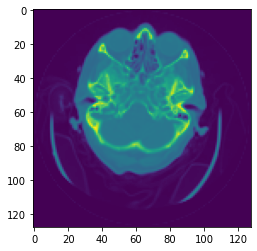

In [9]:
img = mpimg.imread('/eos/user/g/gamorell/test/processed/img_0/ID_001c828ec.png')
imgplot = plt.imshow(img)
plt.show()

The next two blocks convert our data in numpy arrays and save them, labels on the second array belong to the correspondent image given a certain index. 
img_to_npy takes every image and appends it to a images list as a numpy array, at the end we save the resulting list in a .npy file.

In [10]:
def img_to_npy():
    images = []
    for root, dirs, files in os.walk(output_dicom_folder):
        for file in files:
            images.append(np.array(Image.open(root + '/' + file)))
    train_img = np.array(images)
    np.save(backup_npy + 'train_img.npy', train_img)
img_to_npy()


labels_to_npy create a npy file with all the labels taken from the csv file, it slice the string to have just the ID, in the cycle we take every file as the last function and we look in the csv for the correspondent label, we append the label in a list and we store it as a numpy array

In [11]:
def labels_to_npy():
    data = pd.read_csv(output_csv_path) #ID_122314_any
    data["ID"] = data["ID"].str.slice(stop = 12) ##ID_122314
    labels = []
    for root, dirs, files in os.walk(output_dicom_folder):
        for file in files:
            ID = file.split('.')[0]
            labels.append(data[data["ID"] == ID].Label.values[0])
    train_labels = np.array(labels)
    np.save(backup_npy + 'train_labels.npy', train_labels)
labels_to_npy()